<a href="https://colab.research.google.com/github/vsay01/Building_Classifier/blob/master/Building_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building Classifier
--- You are a data scientist at vacation rental company. So far company was doing good differentiating itself as a company renting single family vacation homes only. Vocation season is about to start, customers renting, and homeowners are listing. Quality control team is overwhelmed. Team is asking is there way to make their life easier. Ypu just accepted the challenge of classifying listing automatically. As a proof of concept you start with 2 big classes residential, industrial. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
os.chdir('drive/My Drive/MyDrive/Udacity/staticmap')

In [4]:
%ls

Building-classifier.ipynb  staticmap/  staticmap.zip


In [0]:
#!unzip staticmap

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torch.nn as nn

In [6]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Import Datasets

In [0]:
#%mkdir checkpoint best_model

In [8]:
%ls

best_model/  Building-classifier.ipynb  checkpoint/  staticmap/


In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),  # Image net standards
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
total_data =  datasets.ImageFolder('staticmap', transform=transform)

# choose the training and test datasets
train_data =  datasets.ImageFolder('staticmap/train', transform=transform)
test_data =  datasets.ImageFolder('staticmap/test', transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

data_loaders = {
    'train' : train_loader,
    'valid' : valid_loader,
    'test'  : test_loader
}


Define Classes

In [14]:
# specify the image classes
# classes = ["residential", "industrial"]
classes = [item[0:].replace("_", " ") for item in train_data.classes]
classes

['industrial', 'residential']

In [15]:
len(train_idx)

1611

### Visualize a Batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

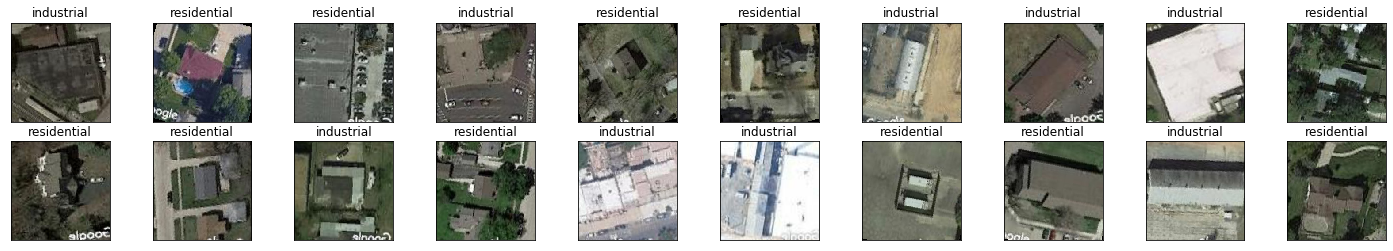

In [17]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Helper functions

In [0]:
import torch
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [0]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # initialize train_loss_coll from checkpoint to train_loss_coll
    train_loss_coll = checkpoint['train_loss_coll']
    # initialize valid_loss_coll from checkpoint to valid_loss_coll
    valid_loss_coll = checkpoint['valid_loss_coll']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min, train_loss_coll, valid_loss_coll

In [0]:
def train(start_epochs, n_epochs, valid_loss_min_input, loaders, model, optimizer, criterion, use_cuda, checkpoint_path, best_model_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = valid_loss_min_input 
    
    train_loss_coll = []
    valid_loss_coll = []
    
    for epoch in range(start_epochs, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        train_correct = 0.
        train_total = 0.
        
        valid_loss = 0.0
        valid_correct = 0.
        valid_total = 0.        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (train_data, train_target) in enumerate(loaders['train']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                train_data, train_target = train_data.cuda(), train_target.cuda()
            # clear the gradients of all optimized variables    
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            train_output = model(train_data)
            # calculate the batch loss
            loss = criterion(train_output, train_target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update total training loss
            train_loss += loss.item()*train_data.size(0)            
            # convert output logits to predicted class
            train_pred = train_output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(train_pred.eq(train_target.data.view_as(train_pred))).cpu().numpy())
            train_total += train_data.size(0)
                
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for val_batch_idx, (val_data, val_target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                val_data, val_target = val_data.cuda(), val_target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            val_output = model(val_data)
            # calculate the batch loss
            val_loss = criterion(val_output, val_target)
            # update total validation loss 
            valid_loss += val_loss.item()*val_data.size(0)
            # convert output logits to predicted class
            valid_pred = val_output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(valid_pred.eq(val_target.data.view_as(valid_pred))).cpu().numpy())
            valid_total += val_data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        train_acc = 100. * train_correct / train_total
        valid_acc = 100. * valid_correct / valid_total
            
        # print training/validation statistics 
        print('Epoch: {} \tTrain Loss: {:.6f} \tValid Loss: {:.6f} \tTrain Acc: {:.2f} \tValid Acc: {:.2f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            train_acc,
            valid_acc))
        
        train_loss_coll.append(train_loss)
        valid_loss_coll.append(valid_loss)
        
        checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_loss_coll':train_loss_coll,
            'valid_loss_coll':valid_loss_coll,
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
        ## Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss
            ))
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)    
            valid_loss_min = valid_loss   
            
    # return trained model
    return model, train_loss_coll, valid_loss_coll

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output logits to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

## Transfer Learning

In [22]:
# check if CUDA is available
USE_GPU = True # currently GPU not available
use_cuda = USE_GPU and torch.cuda.is_available()
print(use_cuda)

True


### MobileV2 model

In [23]:
###Define pretrained model
model_transfer_mobilev2 = models.mobilenet_v2(pretrained=True)
    
print(model_transfer_mobilev2)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth



MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=T

Freez parameters

In [0]:
# Freeze parameters so we don't backprop through them
for param in model_transfer_mobilev2.parameters():
    param.requires_grad = False

n_inputs = model_transfer_mobilev2.classifier[1].in_features
n_classes = len(classes)
model_transfer_mobilev2.classifier = nn.Sequential(
                      nn.Dropout(0.2, inplace = False),
                      nn.Linear(n_inputs, n_classes, bias = True))

# Unfreeze training for classifier layers   
for param in model_transfer_mobilev2.classifier.parameters():
    param.requires_grad = True

In [0]:
if use_cuda:
    model_transfer_mobilev2 = model_transfer_mobilev2.cuda()

In [27]:
print(model_transfer_mobilev2)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

Define creterion and optimizer 

In [0]:
# Only train the classifier parameters, feature parameters are frozen
criterion_mobilev2 = nn.CrossEntropyLoss()
optimizer_mobilev2 = optim.Adam(model_transfer_mobilev2.classifier.parameters(), lr=0.001)

In [33]:
model_mobilev2, train_loss_coll_mobilev2, valid_loss_coll_mobilev2 = train(1, 25, np.Inf, data_loaders, model_transfer_mobilev2, optimizer_mobilev2, criterion_mobilev2, use_cuda, "./checkpoint/current_checkpoint_mobilev2.pt", "./best_model/best_model_mobilev2.pt")

Epoch: 1 	Train Loss: 0.380381 	Valid Loss: 0.072337 	Train Acc: 77.84 	Valid Acc: 84.08
Validation loss decreased (inf --> 0.072337).  Saving model ...
Epoch: 2 	Train Loss: 0.312332 	Valid Loss: 0.064442 	Train Acc: 82.50 	Valid Acc: 86.82
Validation loss decreased (0.072337 --> 0.064442).  Saving model ...
Epoch: 3 	Train Loss: 0.289368 	Valid Loss: 0.064170 	Train Acc: 84.36 	Valid Acc: 84.83
Validation loss decreased (0.064442 --> 0.064170).  Saving model ...
Epoch: 4 	Train Loss: 0.273732 	Valid Loss: 0.062466 	Train Acc: 86.10 	Valid Acc: 87.56
Validation loss decreased (0.064170 --> 0.062466).  Saving model ...
Epoch: 5 	Train Loss: 0.269615 	Valid Loss: 0.060768 	Train Acc: 85.23 	Valid Acc: 89.05
Validation loss decreased (0.062466 --> 0.060768).  Saving model ...
Epoch: 6 	Train Loss: 0.271509 	Valid Loss: 0.058555 	Train Acc: 86.03 	Valid Acc: 87.81
Validation loss decreased (0.060768 --> 0.058555).  Saving model ...
Epoch: 7 	Train Loss: 0.267732 	Valid Loss: 0.065063 	Tra

### densenet121


In [34]:
model_densenet121 = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [35]:
model_densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
# Freeze parameters so we don't backprop through them
for param in model_densenet121.parameters():
    param.requires_grad = False

n_inputs = model_densenet121.classifier.in_features
n_classes = len(classes)
model_densenet121.classifier = nn.Linear(n_inputs, n_classes, bias = True)

# Unfreeze training for classifier layers   
for param in model_densenet121.classifier.parameters():
    param.requires_grad = True

In [0]:
if use_cuda:
    model_densenet121 = model_densenet121.cuda()

In [38]:
model_densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
# Only train the classifier parameters, feature parameters are frozen
criterion_densenet121 = nn.CrossEntropyLoss()
optimizer_densenet121 = optim.Adam(model_densenet121.classifier.parameters(), lr=0.001)

In [41]:
model_densenet121, train_loss_coll_densenet121, valid_loss_coll_densenet121 = train(1, 25, np.Inf, data_loaders, model_densenet121, optimizer_densenet121, criterion_densenet121, use_cuda, "./checkpoint/current_checkpoint_densenet121.pt", "./best_model/best_model_densenet121.pt")

Epoch: 1 	Train Loss: 0.446052 	Valid Loss: 0.082310 	Train Acc: 71.14 	Valid Acc: 85.07
Validation loss decreased (inf --> 0.082310).  Saving model ...
Epoch: 2 	Train Loss: 0.339542 	Valid Loss: 0.068817 	Train Acc: 81.25 	Valid Acc: 86.07
Validation loss decreased (0.082310 --> 0.068817).  Saving model ...
Epoch: 3 	Train Loss: 0.302434 	Valid Loss: 0.072498 	Train Acc: 84.17 	Valid Acc: 83.33
Epoch: 4 	Train Loss: 0.289127 	Valid Loss: 0.063048 	Train Acc: 84.98 	Valid Acc: 87.31
Validation loss decreased (0.068817 --> 0.063048).  Saving model ...
Epoch: 5 	Train Loss: 0.269460 	Valid Loss: 0.058341 	Train Acc: 85.85 	Valid Acc: 89.80
Validation loss decreased (0.063048 --> 0.058341).  Saving model ...
Epoch: 6 	Train Loss: 0.252743 	Valid Loss: 0.066671 	Train Acc: 87.65 	Valid Acc: 84.33
Epoch: 7 	Train Loss: 0.274487 	Valid Loss: 0.066769 	Train Acc: 85.04 	Valid Acc: 85.82
Epoch: 8 	Train Loss: 0.255181 	Valid Loss: 0.061435 	Train Acc: 87.15 	Valid Acc: 86.82
Epoch: 9 	Train L

### VGG16

In [53]:
model_vgg16 = models.vgg16(pretrained=True)
model_vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Freeze parameters so we don't backprop through them
for param in model_vgg16.parameters():
    param.requires_grad = False

n_inputs = model_vgg16.classifier[6].in_features
n_classes = len(classes)
model_vgg16.classifier[6] = nn.Linear(n_inputs, n_classes, bias = True)

# Unfreeze training for classifier layers   
for param in model_vgg16.classifier.parameters():
    param.requires_grad = True

In [56]:
if use_cuda:
    model_vgg16 = model_vgg16.cuda()
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Only train the classifier parameters, feature parameters are frozen
criterion_vgg16 = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(model_vgg16.classifier.parameters(), lr=0.001)

In [58]:
model_vgg16, train_loss_coll_vgg16, valid_loss_coll_vgg16 = train(1, 25, np.Inf, data_loaders, model_vgg16, optimizer_vgg16, criterion_vgg16, use_cuda, "./checkpoint/current_checkpoint_vgg16.pt", "./best_model/best_model_vgg16.pt")

Epoch: 1 	Train Loss: 0.596749 	Valid Loss: 0.066430 	Train Acc: 76.66 	Valid Acc: 88.31
Validation loss decreased (inf --> 0.066430).  Saving model ...
Epoch: 2 	Train Loss: 0.372656 	Valid Loss: 0.075415 	Train Acc: 84.11 	Valid Acc: 87.56
Epoch: 3 	Train Loss: 0.396105 	Valid Loss: 0.072054 	Train Acc: 84.42 	Valid Acc: 85.82
Epoch: 4 	Train Loss: 0.317408 	Valid Loss: 0.088149 	Train Acc: 86.03 	Valid Acc: 84.58
Epoch: 5 	Train Loss: 0.334597 	Valid Loss: 0.096696 	Train Acc: 86.16 	Valid Acc: 83.83
Epoch: 6 	Train Loss: 0.289067 	Valid Loss: 0.131814 	Train Acc: 87.15 	Valid Acc: 83.33
Epoch: 7 	Train Loss: 0.275904 	Valid Loss: 0.078914 	Train Acc: 88.33 	Valid Acc: 86.07
Epoch: 8 	Train Loss: 0.242452 	Valid Loss: 0.084600 	Train Acc: 89.70 	Valid Acc: 85.07
Epoch: 9 	Train Loss: 0.227118 	Valid Loss: 0.128164 	Train Acc: 89.08 	Valid Acc: 85.57
Epoch: 10 	Train Loss: 0.238366 	Valid Loss: 0.064640 	Train Acc: 90.88 	Valid Acc: 88.31
Validation loss decreased (0.066430 --> 0.064

## Visualize Loss History

<Figure size 432x288 with 0 Axes>

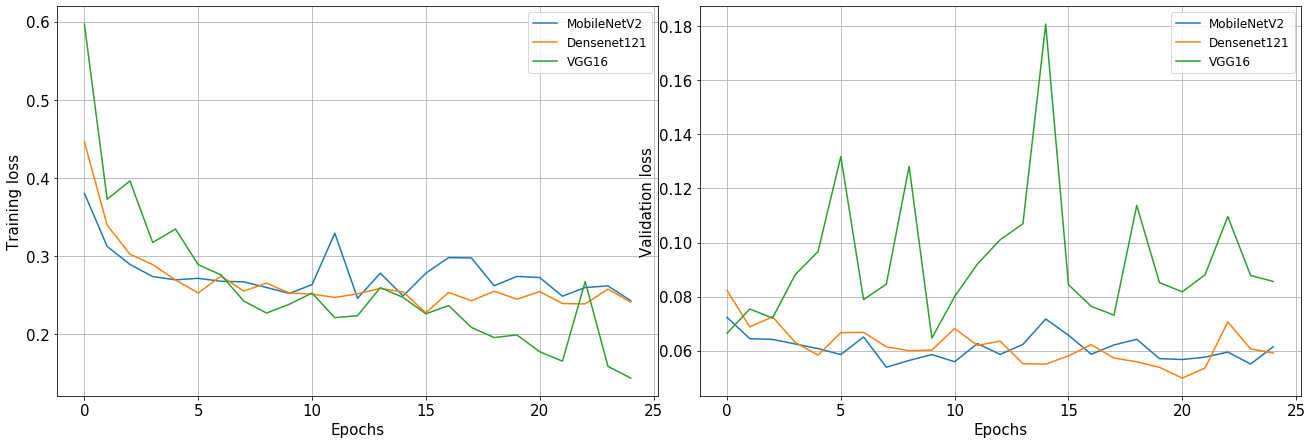

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

epochs = range(0,25)

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
fsize = 15

ax1.plot(epochs, train_loss_coll_mobilev2, label='MobileNetV2')
ax1.plot(epochs, train_loss_coll_densenet121, label='Densenet121')
ax1.plot(epochs, train_loss_coll_vgg16, label='VGG16')
ax1.set_xlabel('Epochs', fontsize = fsize)
ax1.set_ylabel('Training loss', fontsize = fsize)
ax1.legend()
ax1.tick_params(labelsize = fsize)
ax1.grid()
ax1.legend(fontsize = 12)

ax2.plot(epochs, valid_loss_coll_mobilev2, label='MobileNetV2')
ax2.plot(epochs, valid_loss_coll_densenet121, label='Densenet121')
ax2.plot(epochs, valid_loss_coll_vgg16, label='VGG16')
ax2.set_xlabel('Epochs', fontsize = fsize)
ax2.set_ylabel('Validation loss', fontsize = fsize)
ax2.legend()
ax2.tick_params(labelsize = fsize)
ax2.grid()
ax2.legend(fontsize = 12)

plt.savefig('model_comparison.png', bbox_inches='tight', orientation='landscape', dpi=300)

## Inference

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output logits to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [65]:
# Test the performance of the model with the lowest validation loss on the test data
test(data_loaders, model_mobilev2, criterion_mobilev2, use_cuda)

Test Loss: 0.252574


Test Accuracy: 88% (266/300)


In [50]:
# Test the performance of the model with the lowest validation loss on the test data
test(data_loaders, model_densenet121, criterion_densenet121, use_cuda)

Test Loss: 0.196773


Test Accuracy: 94% (282/300)


In [60]:
# Test the performance of the model with the lowest validation loss on the test data
test(data_loaders, model_vgg16, criterion_vgg16, use_cuda)

Test Loss: 0.409700


Test Accuracy: 92% (277/300)
